In [12]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import imutils

import torch
import torchvision.transforms as transforms
from torchvision import datasets

import os
import zipfile

### Data preprocessing
In this section the goal is to apply transofrmations for initial images to increase their quality in terms of training a deep learning algorithm. \
Here adaptive cropping is implemented: reducing boundaries of the images up to a brain contour. \
After that, `X_train, y_train` are formed from the transformed dataset with labels.

In [ ]:
with zipfile.ZipFile('../data/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('../data')

In [2]:
folder_train_path = '../data/archive/Training'
folder_test_path = '../data/archive/Testing'

pre_folder_train_path = '../data/dataset/Training'
pre_folder_test_path = '../data/dataset/Testing'

Categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

In [4]:
def mkdir(comb_folder_path):
    os.makedirs(comb_folder_path, exist_ok=True)
    
mkdir(pre_folder_train_path)
mkdir(pre_folder_test_path)

In [5]:
def load_transform_dataset(folder_path, output_folder_path):
    images = []
    flag1  = 0
    flag2  = 0
    j = 0
    IMG_SIZE = 224
    dim = (IMG_SIZE, IMG_SIZE)
    
    for filename in os.listdir(folder_path):    
        img = cv2.imread(os.path.join(folder_path, filename))
    
        image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        #CROP  
        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # add contour on the image
        img_cnt = cv2.drawContours(image.copy(), [c], -1, (0, 255, 255), 4)

        # add extreme points
        img_pnt = cv2.circle(img_cnt.copy(), extLeft, 5, (0, 0, 255), -1)
        img_pnt = cv2.circle(img_pnt, extRight, 5, (0, 255, 0), -1)
        img_pnt = cv2.circle(img_pnt, extTop, 5, (255, 0, 0), -1)
        img_pnt = cv2.circle(img_pnt, extBot, 5, (255, 255, 0), -1)

        # apply crop
        ADD_PIXELS = 0
        new_image = image[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        #Display crops
#         plt.figure(figsize=(15,6))
#         plt.subplot(141)
#         plt.imshow(img)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title('Step 1. Get the original image')
#         plt.subplot(142)
#         plt.imshow(new_image)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title('Step 4. Crop the image')
#         plt.show()
        
        images.append(new_image)
        cv2.imwrite(os.path.join(output_folder_path , filename), new_image)
    return images

In [6]:
def flatten(x):
    return [el for el_set in x for el in el_set]

In [7]:
train_set, test_set, train_label = [], [], []
for category in Categories:
    train_path, output_train_path = os.path.join(folder_train_path, category), os.path.join(pre_folder_train_path, category)
    test_path, output_test_path = os.path.join(folder_test_path, category), os.path.join(pre_folder_test_path, category)

    train_set.append(load_transform_dataset(train_path, output_train_path))
    test_set.append(load_transform_dataset(test_path, output_test_path))
    
    train_label.append(np.full(len(train_set), Categories.index(category)))

train_set = flatten(train_set)
test_set = flatten(test_set)
train_label = flatten(train_label)

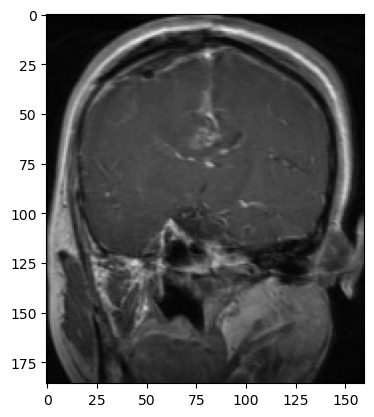

In [8]:
plt.imshow(train_set[5])

In [9]:
train_set[5].shape

(186, 160, 3)

In [10]:
X_train, y_train = [torch.from_numpy(item).float() for item in train_set], train_label

Train_set consists of images 512x512. \
Test_set consists of images with different size. 